In [21]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [22]:
!cd gdrive/MyDrive/

In [23]:
!ls

gdrive	sample_data


In [24]:
!pip install jitcdde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jitcdde: filename=jitcdde-1.8.1-py3-none-any.whl size=55003 sha256=ceab45798f1e3408fb47cbbe366c8eae20b95a5af4cdd4a544e7639b728e0293
  Stored in directory: /root/.cache/pip/wheels/42/e3/4e/94b61188e5e3e62ba27e9586da5ecc7ea0f24e26916a250cc7
  Created wheel for chspy: filename=CHSPy-1.2.2-py3-none-any.whl size=11999 sha256=41dc680fb77b83313d52d0c3b938132434da2be24e9c8cb490de6f9c11139de3
  Stored in directory: /root/.cache/pip/wheels/11/17/24/0cca70842afd051f54325b813e637d8e8836d88c286ba63fae
  Created wheel for jitcxde_common: filename=jitcxde_common-1.5.4-py3-none-any.whl size=16755 sha256=a8db8f5dfe93c480ffed54b2ed5cd50c1bd3ec484a270b02e24f17ac3db66f75
  Stored in directory: /root/.cach

In [39]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from jitcdde import jitcdde, y, t
from numpy import pi, arange, random, max
import symengine

In [26]:
count_file_path = "gdrive/MyDrive/PBM-report2/budapest_connectome_3.0_209_0_median_fc_20k.csv"
length_file_path = "gdrive/MyDrive/PBM-report2/budapest_connectome_3.0_209_0_median_20k.csv"

In [27]:
def get_weights_of_nodes(count_file_path, length_file_path):
    df_count = pd.read_csv(count_file_path, delimiter=';')
    df_len = pd.read_csv(length_file_path, delimiter=';')

    df_merged = pd.merge(df_count, df_len, how='inner',
                     left_on=['parent id node1', 'parent id node2'],
                     right_on=['parent id node1', 'parent id node2'])

    df_merged = df_merged[['parent id node1', 'parent id node2', 'edge weight(med nof)', 'edge weight(med flm)']]
    df_merged = df_merged.rename(columns={'parent id node1':'node1', 'parent id node2':'node2', 'edge weight(med nof)':'fiber_count', 'edge weight(med flm)':'fiber_length'})

    l = df_merged["node1"].astype('int')
    print(f"Max node id{max(l)}")

    # Extract the necessary information
    nodes = np.union1d(df_merged['node1'].values, df_merged['node2'].values)
    num_nodes = len(nodes)
    edges = list(zip(df_merged['node1'], df_merged['node2']))

    print(f"# nodes:{num_nodes}, # edges:{len(edges)}")

    # Create a mapping from node ID to index
    node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

    w_kj = np.zeros((num_nodes, num_nodes))


    for _, row in df_merged.iterrows():
        idx1 = node_to_index[row['node1']]
        idx2 = node_to_index[row['node2']]
        weight = row['fiber_count']/row['fiber_length']
        w_kj[idx1, idx2] = weight
        w_kj[idx2, idx1] = weight

    return df_merged, w_kj, num_nodes, node_to_index

Max node id83
# nodes:76, # edges:11288


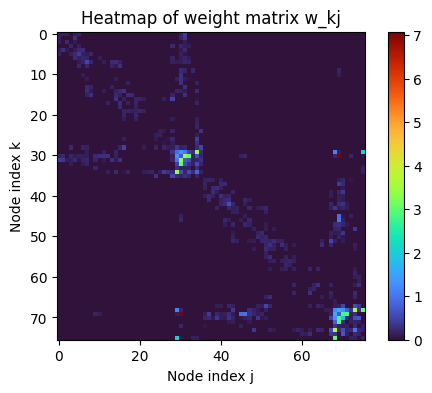

In [28]:
data, w_kj, num_nodes, node_to_index = get_weights_of_nodes(count_file_path, length_file_path)

# Plotting the heatmap
plt.figure(figsize=(6, 4))
heatmap = plt.imshow(w_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

In [39]:
data.head()

,node1,node2,fiber_count,fiber_length
0,9,37,25.0,22.239342
1,9,37,25.0,26.385718
2,9,37,25.0,36.416003
3,9,37,25.0,32.376669
4,9,37,25.0,27.144929


In [29]:
w_kj.shape


(76, 76)

# Delays
Preparing tau_kj (delays) with steps like qcut, taking mean, plotting distribution



Min:7.733333333333333, Max:32.79998666666666


<Axes: xlabel='delay', ylabel='Density'>

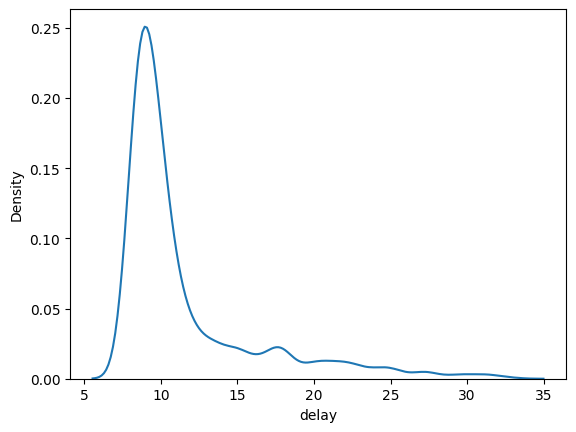

In [30]:
data['delay'] = data['fiber_length'] / 1.5
print(f"Min:{data['delay'].min()}, Max:{data['delay'].max()}")
sns.kdeplot(data, x="delay")

In [31]:
data['delay_interval'] = pd.qcut(data['delay']/1000, q=40)
# for i in range(len(data['delay_interval'].unique())):
#   print(f"{i}:{data['delay_interval'].unique()[i]}")

# Calculate midpoints
midpoints = data['delay_interval'].apply(lambda x: x.mid).unique()

# Map each interval to its midpoint
interval_to_midpoint = {interval: interval.mid for interval in data['delay_interval'].unique()}
data['delay_discrete'] = data['delay_interval'].map(interval_to_midpoint).astype(float)
data.head()

,node1,node2,fiber_count,fiber_length,delay,delay_interval,delay_discrete
0,9,37,25.0,22.239342,14.826228,"(0.0148, 0.016]",0.0154
1,9,37,25.0,26.385718,17.590479,"(0.0175, 0.0183]",0.0179
2,9,37,25.0,36.416003,24.277335,"(0.0227, 0.0255]",0.0241
3,9,37,25.0,32.376669,21.584446,"(0.0205, 0.0227]",0.0216
4,9,37,25.0,27.144929,18.096619,"(0.0175, 0.0183]",0.0179


In [32]:
grouped = data.groupby(['node1', 'node2'])['delay_discrete'].agg(['count', 'mean']).reset_index()
# print(grouped.describe())
grouped.head(10)

,node1,node2,count,mean
0,1,1,25,0.012219
1,1,4,1,0.008445
2,1,5,81,0.012016
3,1,7,25,0.012850
4,1,8,1,0.010400
5,1,36,9,0.016450
6,1,37,121,0.014542
7,4,7,25,0.008903
8,4,36,16,0.010596
9,4,37,4,0.017400


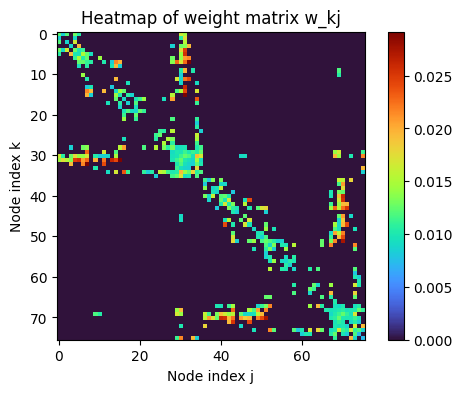

In [33]:
tau_kj = np.zeros((num_nodes, num_nodes))

for _, row in grouped.iterrows():
    idx1 = node_to_index[row['node1']]
    idx2 = node_to_index[row['node2']]

    weight = row['mean']
    tau_kj[idx1, idx2] = weight
    tau_kj[idx2, idx1] = weight

# Plotting the heatmap
plt.figure(figsize=(6, 4))
heatmap = plt.imshow(tau_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

#DDE
Code to simulate the distributed delayed differential equations for the resting state brain dynamics

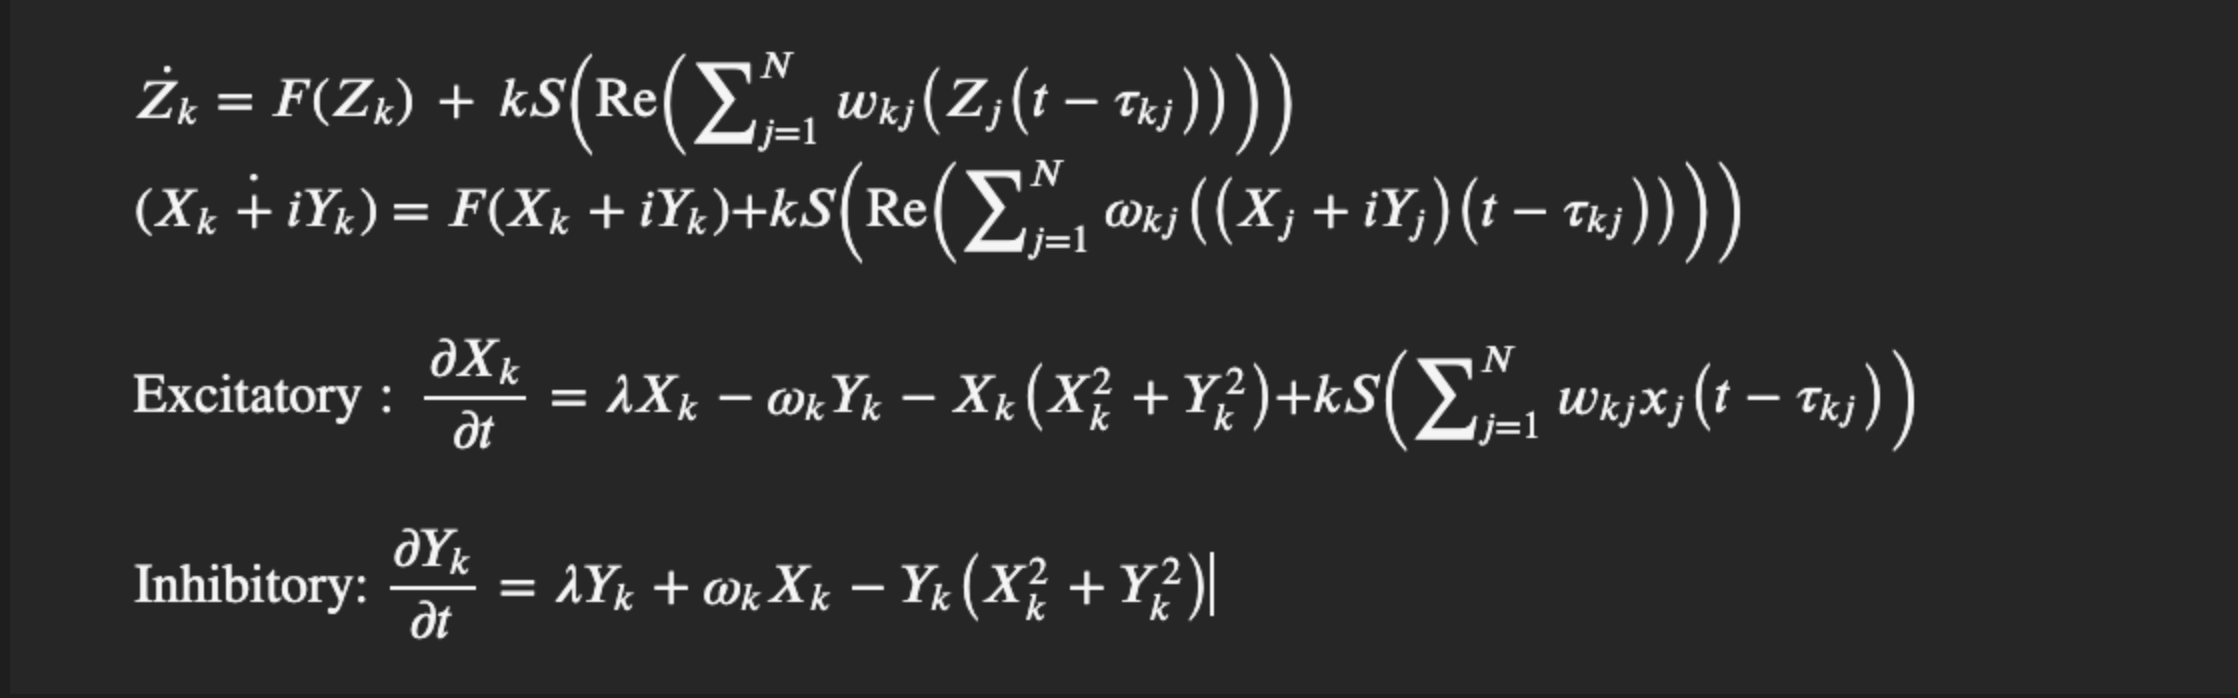


In [35]:
def sigmoid(x):
    return 1 / (1 + symengine.exp(-x))

In [88]:
n = num_nodes
mean_omega = 40
variance_omega = 0.1
ω = np.random.normal(mean_omega, np.sqrt(variance_omega), n)
c = 42
λ = -0.01
A = w_kj
τ = tau_kj
k = 10

def kuramotos():
  for i in range(n):
    # calculate the coupling sum for excitatory population
    coupling_sum = sum( A[i,j]*y(2*j, t-τ[i,j]) for j in range(n) )
    # apply the sigmoid functuon to the coupling term
    coupling_term = sigmoid(coupling_sum)

    # Excitatory population equation
    yield λ * y(2*i) - ω[i]*y(2*i+1) - y(2*i) * (y(2*i)**2 + y(2*i+1)**2) + k*coupling_term

    # Inhibitory population equation
    yield λ * y(2*i+1) + ω[i]*y(2*i) - y(2*i+1) * (y(2*i)**2 + y(2*i+1)**2)

I = jitcdde(kuramotos,n=2*n,verbose=False,delays=τ.flatten())
I.set_integration_parameters(rtol=0,atol=1e-5)

I.constant_past( np.random.rand(n*2), time=0.0 )
I.integrate_blindly( max(τ) , 0.01 )

# Time span for integration (10 seconds)
t_end = 15
dt = 0.01  # Adjust dt to the desired time resolution
times = np.arange(5, t_end, dt)
data = np.zeros((len(times), n*2))  # Pre-allocate space for efficiency

# for time in I.t + arange(0,10,0.01):
#   print(I.integrate(time))

# Integrate and store the data
for i, time in enumerate(times):
    data[i] = I.integrate(time)

In [89]:
exc = data[:,:76]
inh = data[:,76:]

In [90]:
print(exc.shape, inh.shape)

(1000, 76) (1000, 76)


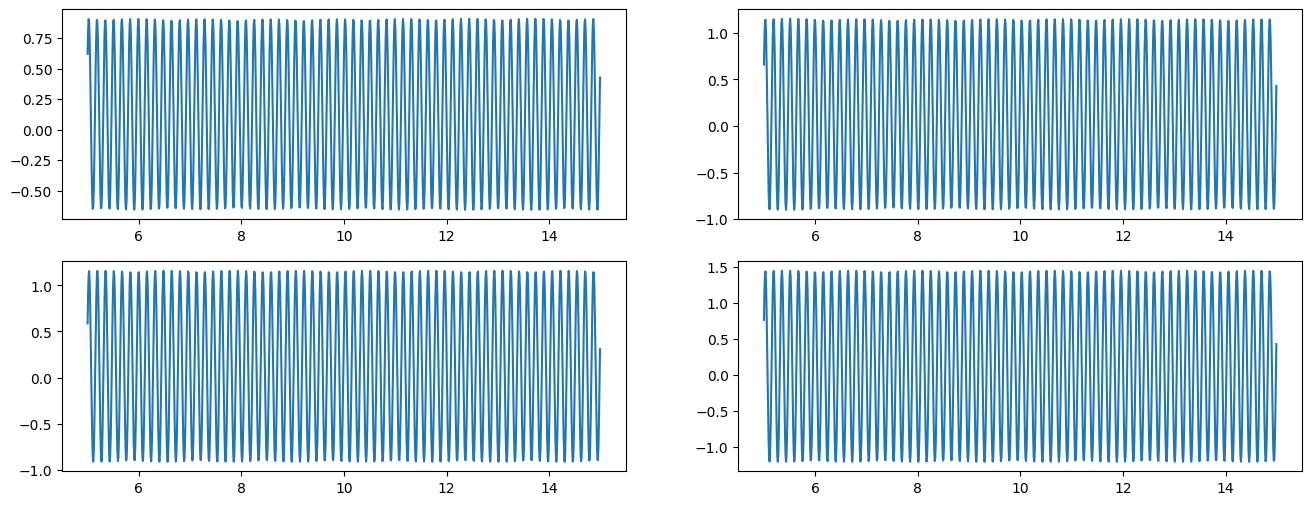

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(16,6))

ax[0, 0].plot(times, exc[:,25], label="26th Excitatory")
ax[0, 1].plot(times, inh[:,25], label="26th Excitatory")

ax[1, 0].plot(times, exc[:,67], label="68th Excitatory")
ax[1, 1].plot(times, inh[:,67], label="68th Excitatory")